Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [0]:
%%capture
!pip install category_encoders==2.*
!pip install eli5

In [0]:
import sys
import pandas as pd
# import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [0]:
sample = 'https://raw.githubusercontent.com/michael-rowland/Pitch-Predictions/master/sample.csv'
df = pd.read_csv(sample)

In [0]:
initial_features = ['pitch_name', 'game_date', 'description', 'zone', 'des', 
                    'stand', 'type', 'bb_type', 'balls', 'strikes', 'on_3b', 
                    'on_2b', 'on_1b', 'outs_when_up', 'inning', 'at_bat_number',
                    'pitch_number', 'bat_score', 'fld_score']

df = df[initial_features]
df = df[df['game_date'] == '2018-09-28']
# df.head()

In [0]:
def pitch_counter(df):

  df = df.copy()
  
  # I THINK THIS SHOULD BE ABLE TO BE REPLACED WITH .rolling
  df['4fastball_count'] = 0
  df['2fastball_count'] = 0
  df['curveball_count'] = 0
  df['changeup_count'] = 0

  four_fastball_counter = 0
  two_fastball_counter = 0
  curveball_counter = 0
  changeup_counter = 0

  for i in range(len(df)):
    if df.loc[i, 'previous_pitch'] == '4-Seam Fastball':
      four_fastball_counter += 1
    df['4fastball_count'].iloc[i] = four_fastball_counter

    if df.loc[i, 'previous_pitch'] == '2-Seam Fastball':
      two_fastball_counter += 1
    df['2fastball_count'].iloc[i] = two_fastball_counter

    if df.loc[i, 'previous_pitch'] == 'Curveball':
      curveball_counter += 1
    df['curveball_count'].iloc[i] = curveball_counter

    if df.loc[i, 'previous_pitch'] == 'Changeup':
      changeup_counter += 1
    df['changeup_count'].iloc[i] = changeup_counter
    
  return df

In [0]:
def pitch_tendency(df, window):

  df = df.copy()
  
  # USE AN ENCODER HERE
  df['4fastball'] = (df['previous_pitch'] == '4-Seam Fastball') * 1
  df['2fastball'] = (df['previous_pitch'] == '2-Seam Fastball') * 1
  df['curveball'] = (df['previous_pitch'] == 'Curveball') * 1
  df['changeup'] = (df['previous_pitch'] == 'Changeup') * 1

  df[f'4fastball_tendency_{window}'] = df['4fastball'].rolling(
      window, min_periods=1).mean()
  df[f'2fastball_tendency_{window}'] = df['2fastball'].rolling(
      window, min_periods=1).mean()
  df[f'curveball_tendency_{window}'] = df['curveball'].rolling(
      window, min_periods=1).mean()
  df[f'changeup_tendency_{window}'] = df['changeup'].rolling(
      window, min_periods=1).mean()

  return df

In [54]:
def wrangle(df):
  
  df = df.copy()

  # FLIPS DATA SO FIRST PITCHES ARE ON TOP
  df = df.reindex(index=df.index[::-1])
  df = df.reset_index()
  
  # CALCULATES SCORE MARGIN
  df['score_margin'] = df['fld_score'] - df['bat_score']
  df = df.drop(['fld_score', 'bat_score'], axis=1)

  # CALCULATES TOTAL PITCHES THROWN SINCE ENTERING GAME
  df['pitch_total'] = df.groupby('game_date').cumcount(ascending=True)+1

  # MAPS 1b/2b/3b TO BOOLEAN
  df['on_1b'] = df['on_1b'].notnull()
  df['on_2b'] = df['on_2b'].notnull()
  df['on_3b'] = df['on_3b'].notnull()

  # CREATES 'at_bat_count' FROM 'at_bat_number'
  '''This probably needs to be updated when I update apply groupby function for date'''
  df['at_bat_count'] = df.groupby('at_bat_number').ngroup(ascending=True)+1
  df = df.drop('at_bat_number', axis=1)

  # CREATES 'pitcher_advantage' COLUMN
  df['count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)
  df['pitcher_advantage'] = df['count'].map({'0-0':'neutral', '0-1':'ahead', 
                                             '0-2':'ahead', '1-0':'neutral', 
                                             '1-1':'neutral', '1-2':'ahead', 
                                             '2-0':'behind', '2-1':'neutral', 
                                             '2-2':'ahead', '3-0':'behind', 
                                             '3-1':'behind', '3-2':'neutral'})
  df = df.drop('count', axis=1)
  

  # PITCH TENDENCIES
  df['previous_pitch'] = df['pitch_name'].shift(1)
  df = pitch_counter(df)
  df = pitch_tendency(df, 5)
  
  return df

df = wrangle(df)
# NEED TO CLEAN UP SettingWithCopyWarning
# Update index change

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [55]:
df = df.drop(['index', 'description', 'zone', 'des', 'type', 'bb_type'], axis=1)
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105
pitch_name,4-Seam Fastball,Changeup,4-Seam Fastball,4-Seam Fastball,4-Seam Fastball,4-Seam Fastball,Curveball,4-Seam Fastball,Curveball,4-Seam Fastball,Curveball,Curveball,4-Seam Fastball,2-Seam Fastball,Curveball,2-Seam Fastball,2-Seam Fastball,Curveball,2-Seam Fastball,2-Seam Fastball,2-Seam Fastball,4-Seam Fastball,4-Seam Fastball,Curveball,Curveball,4-Seam Fastball,2-Seam Fastball,4-Seam Fastball,2-Seam Fastball,4-Seam Fastball,Curveball,2-Seam Fastball,4-Seam Fastball,Curveball,Curveball,2-Seam Fastball,2-Seam Fastball,Curveball,4-Seam Fastball,Curveball,2-Seam Fastball,4-Seam Fastball,4-Seam Fastball,Curveball,2-Seam Fastball,Changeup,2-Seam Fastball,Curveball,2-Seam Fastball,2-Seam Fastball,Changeup,4-Seam Fastball,4-Seam Fastball,Changeup,2-Seam Fastball,2-Seam Fastball,Curveball,2-Seam Fastball,4-Seam Fastball,4-Seam Fastball,4-Seam Fastball,2-Seam Fastball,Curveball,2-Seam Fastball,Curveball,Curveball,4-Seam Fastball,4-Seam Fastball,Curveball,Curveball,4-Seam Fastball,2-Seam Fastball,Curveball,Curveball,4-Seam Fastball,4-Seam Fastball,2-Seam Fastball,2-Seam Fastball,Curveball,Curveball,Curveball,2-Seam Fastball,2-Seam Fastball,Curveball,2-Seam Fastball,Changeup,4-Seam Fastball,Curveball,4-Seam Fastball,Curveball,4-Seam Fastball,2-Seam Fastball,4-Seam Fastball,4-Seam Fastball,Curveball,2-Seam Fastball,Curveball,Curveball,Curveball,2-Seam Fastball,2-Seam Fastball,Curveball,4-Seam Fastball,Curveball,Curveball,4-Seam Fastball
game_date,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28,2018-09-28
stand,L,L,L,L,L,L,L,L,R,R,R,R,R,L,R,R,R,R,R,R,L,L,L,R,R,R,R,R,R,R,R,R,R,R,R,R,L,L,L,L,L,L,L,L,L,L,R,R,L,L,L,L,L,L,R,R,R,L,L,L,L,L,R,R,R,R,R,R,R,R,R,R,R,L,L,L,L,L,L,R,R,R,R,R,L,L,L,L,R,R,R,L,L,L,R,R,R,R,R,R,R,R,R,R,R,R
balls,0,0,1,1,0,0,0,1,0,0,1,2,2,0,0,0,1,2,2,3,0,0,0,0,1,1,2,2,0,0,0,0,1,1,2,3,0,1,1,1,0,0,0,0,1,2,0,0,0,1,2,2,2,3,0,0,0,0,1,2,3,3,0,1,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,2,3,0,0,0,1,0,0,0,0,0,0,0,1,1,1,2,3,0,0,0,0,1,2
strikes,0,1,1,2,0,1,2,2,0,1,1,1,2,0,0,1,1,1,2,2,0,1,2,0,0,1,1,2,0,1,2,0,0,1,1,1,0,0,1,2,0,1,2,2,2,2,0,1,0,0,0,1,2,2,0,1,2,0,0,0,0,1,0,0,1,1,0,1,2,2,0,1,2,0,1,2,2,0,1,0,0,0,1,1,0,1,2,2,0,1,2,0,1,2,0,0,1,2,2,2,0,0,1,2,2,2
on_3b,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.8, random_state=42)
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [0]:
target = 'pitch_name'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [60]:
# BASELINE
y_train.value_counts(normalize=True)[0]

0.34328358208955223

In [62]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.4117647058823529


In [69]:
import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [70]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [71]:
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [72]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

2fastball_count        -5.882353e-02
balls                  -4.705882e-02
inning                 -4.705882e-02
4fastball_tendency_5   -2.352941e-02
curveball              -2.352941e-02
changeup_count         -2.352941e-02
2fastball_tendency_5   -1.176471e-02
4fastball_count        -1.176471e-02
previous_pitch         -2.220446e-17
game_date               0.000000e+00
changeup                0.000000e+00
2fastball               0.000000e+00
4fastball               0.000000e+00
curveball_count         0.000000e+00
changeup_tendency_5     0.000000e+00
score_margin            0.000000e+00
outs_when_up            0.000000e+00
on_2b                   0.000000e+00
on_3b                   0.000000e+00
strikes                 0.000000e+00
curveball_tendency_5    0.000000e+00
pitch_total             1.176471e-02
on_1b                   2.352941e-02
at_bat_count            2.352941e-02
stand                   2.352941e-02
pitcher_advantage       3.529412e-02
pitch_number            4.705882e-02
d

In [73]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0471 ± 0.0880,pitch_number
0.0353 ± 0.0576,pitcher_advantage
0.0235 ± 0.0576,stand
0.0235 ± 0.0576,at_bat_count
0.0235 ± 0.0941,on_1b
0.0118 ± 0.0880,pitch_total
0 ± 0.0000,curveball_tendency_5
0 ± 0.0000,strikes
0 ± 0.0000,on_3b
0 ± 0.0000,on_2b


In [63]:
# XGBOOST
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.5294117647058824


In [64]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 trees, depends on early stopping
    max_depth=7,        # try deeper trees because of high cardinality categoricals
    learning_rate=0.5,  # try higher learning rate
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='merror', 
          early_stopping_rounds=50) # Stop if the score hasn't improved in 50 rounds

[0]	validation_0-merror:0.134328	validation_1-merror:0.705882
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.089552	validation_1-merror:0.705882
[2]	validation_0-merror:0.044776	validation_1-merror:0.647059
[3]	validation_0-merror:0.014925	validation_1-merror:0.705882
[4]	validation_0-merror:0.014925	validation_1-merror:0.705882
[5]	validation_0-merror:0	validation_1-merror:0.705882
[6]	validation_0-merror:0	validation_1-merror:0.705882
[7]	validation_0-merror:0	validation_1-merror:0.705882
[8]	validation_0-merror:0	validation_1-merror:0.705882
[9]	validation_0-merror:0	validation_1-merror:0.705882
[10]	validation_0-merror:0	validation_1-merror:0.705882
[11]	validation_0-merror:0	validation_1-merror:0.705882
[12]	validation_0-merror:0	validation_1-merror:0.647059
[13]	validation_0-merror:0	validation_1-merror:0.647059
[14]	validation_0-merror:0	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

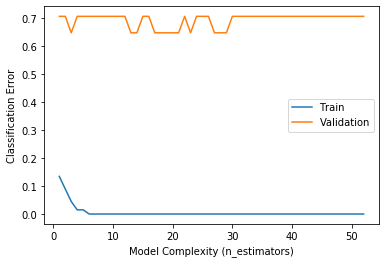

In [67]:
import matplotlib.pyplot as plt

results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
# plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();